\\?\C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(fil

epoch,train_loss,valid_loss,_rmse,time
0,2.332228,3.114287,1.764735,04:40


epoch,train_loss,valid_loss,_rmse,time
0,1.611514,3.096058,1.759562,04:34
1,1.279621,3.169202,1.780225,04:43
2,0.826247,3.121332,1.766729,04:40
3,0.544979,3.158960,1.777346,04:29
4,0.448858,3.155487,1.776369,04:38


✅ Model saved: models/book_recommender_latest.pkl


Top 10 for user 98391:
      user_id     book_id      pred
34686   98391  043936213X  9.966747
22779   98391  0840704593  9.965622
27940   98391  0394823370  9.960220
13454   98391  0451519841  9.953046
2551    98391  0312288476  9.949700
16355   98391  0345317580  9.948723
10564   98391  0373510144  9.946473
26067   98391  0345348109  9.945167
711     98391  043429067X  9.944982
29296   98391  0553213105  9.944687


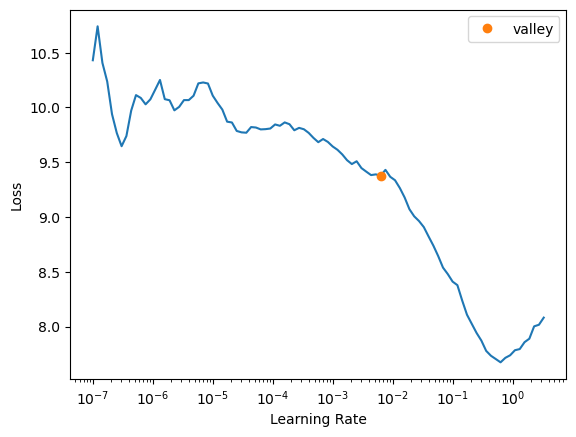

In [16]:
import os, pandas as pd, numpy as np
from fastai.tabular.all import *
from fastai.collab import *
from datetime import datetime

def load_ratings(path='Ratings.csv', sample_size=None):
    df = pd.read_csv(path, sep=',', encoding='latin-1', on_bad_lines='skip')
    df = df.rename(columns={'User-ID': 'user_id', 'ISBN': 'book_id', 'Book-Rating': 'rating'})
    df = df[pd.to_numeric(df['rating'], errors='coerce').notna()]
    df = df[df['rating'].astype(int) > 0]
    df['user_id'], df['book_id'] = df['user_id'].astype(str), df['book_id'].astype(str)
    return df.sample(sample_size, random_state=42) if sample_size else df

def train_model(df, path='models', n_factors=50, y_range=(0,10), bs=64, epochs=5):
    os.makedirs(path, exist_ok=True)
    dls = CollabDataLoaders.from_df(df, user_name='user_id', item_name='book_id', rating_name='rating', bs=bs)
    learn = collab_learner(dls, n_factors=n_factors, y_range=y_range, use_nn=True, metrics=[rmse])
    learn.fine_tune(epochs, learn.lr_find().valley)
    name = f"{path}/book_recommender_latest.pkl"
    learn.export(name)
    print(f"✅ Model saved: {name}")
    return learn

def evaluate_model(learn, df, top_n=10):
    uid = df['user_id'].sample(1).iloc[0]
    rated = set(df[df['user_id'] == uid]['book_id'])
    candidates = list(set(df['book_id']) - rated)
    test_df = pd.DataFrame({'user_id': [uid]*len(candidates), 'book_id': candidates})
    preds = learn.get_preds(dl=learn.dls.test_dl(test_df))[0].numpy()
    test_df['pred'] = preds
    print(f"Top {top_n} for user {uid}:")
    print(test_df.sort_values('pred', ascending=False).head(top_n))

if __name__ == '__main__':
    ratings = load_ratings('Ratings.csv', sample_size=50000)
    learner = train_model(ratings)
    evaluate_model(learner, ratings)

In [19]:
import pandas as pd

# Load original Books.csv
books = pd.read_csv('Books.csv', sep=',', encoding='latin-1', on_bad_lines='skip', low_memory=False)

# Rename columns explicitly (adjust if different)
books.columns = ['book_id', 'title', 'author', 'year', 'publisher', 'img_s', 'img_m', 'img_l']

# Remove image columns
books = books.drop(columns=['img_s', 'img_m', 'img_l'])

# Clean and convert year
books['year'] = pd.to_numeric(books['year'], errors='coerce')
books['year'] = books['year'].fillna(0).astype(int)
books = books[(books['year'] >= 1000) & (books['year'] <= 2025)]

# Save cleaned version
books.to_csv('Books_cleaned.csv', index=False, encoding='utf-8')

print("✅ Cleaned books saved as Books_cleaned.csv without image columns.")


✅ Cleaned books saved as Books_cleaned.csv without image columns.


In [20]:
import pandas as pd

# Load and clean ratings
df = pd.read_csv('Ratings.csv', sep=',', encoding='latin-1', on_bad_lines='skip')
df = df.rename(columns={'User-ID': 'user_id', 'ISBN': 'book_id', 'Book-Rating': 'rating'})

# Drop invalid or missing ratings
df = df[pd.to_numeric(df['rating'], errors='coerce').notna()]
df['rating'] = df['rating'].astype(int)
df = df[df['rating'] > 0]

# Convert IDs to string
df['user_id'], df['book_id'] = df['user_id'].astype(str), df['book_id'].astype(str)

# Optional: remove users or books with too few ratings
user_counts = df['user_id'].value_counts()
book_counts = df['book_id'].value_counts()
df = df[df['user_id'].isin(user_counts[user_counts >= 5].index)]
df = df[df['book_id'].isin(book_counts[book_counts >= 5].index)]

# Save cleaned ratings
df.to_csv('Ratings_cleaned.csv', index=False, encoding='utf-8')

print("✅ Ratings_cleaned.csv saved.")


✅ Ratings_cleaned.csv saved.
